In [2]:
import meep as mp
import matplotlib.pyplot as plt

In [13]:
lambda_min = 0.4
labmda_max = 0.7

c = 3e+8

f_min = c / labmda_max
f_max = c / lambda_min

fcen = 1.75
df = 3.3

In [12]:
print(f"f_min : {f_min:e}")
print(f"f_max : {f_max:e}")

f_min : 4.285714e+08
f_max : 7.500000e+08


In [14]:
pml_layer = 0.3

air_source_center = mp.Vector3(0,0,0)
air_sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=air_source_center,
    size=mp.Vector3(0,0)
)]

boundary_air_layer = [

    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),   # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High),  # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High),  # 상단 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.Low),   # 하단 PML
    
]
resolution_air = 100
sim_air = mp.Simulation(
    cell_size=mp.Vector3(1,1,0),
    default_material=mp.Medium(index=1),
    boundary_layers=boundary_air_layer,
    sources=air_sources,
    resolution=resolution_air
)

-----------
Initializing structure...
time for choose_chunkdivision = 7.60555e-05 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0104511 s
-----------
run 0 finished at t = 50.0 (1000 timesteps)


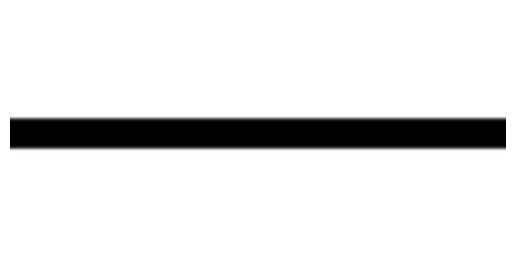

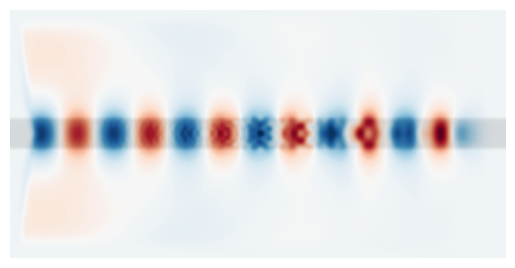

In [19]:
# From the Meep tutorial: plotting permittivity and fields of a straight waveguide
import meep as mp

cell = mp.Vector3(16, 8, 0)

geometry = [
    mp.Block(
        mp.Vector3(mp.inf, 1, mp.inf),
        center=mp.Vector3(),
        material=mp.Medium(epsilon=12),
    )
]

sources = [
    mp.Source(
        mp.ContinuousSource(frequency=0.15), component=mp.Ez, center=mp.Vector3(-7, 0)
    )
]

pml_layers = [mp.PML(1.0)]

resolution = 10

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

sim.run(until=50)

import matplotlib.pyplot as plt
import numpy as np

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.axis("off")
plt.show()

ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="RdBu", alpha=0.9)
plt.axis("off")
plt.show()